# RSA: Modified LeNet-5 x FashionMNIST

*Version History*

* **7.0** - Analyze training results (classification) of modified LeNet-5 networks
* **7.1** - Analyze training results (representational similarity) of modified LeNet-5 networks


## Imports

In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties
from pyfonts import load_font
from torch import nn

from src.models.lenet import LeNet
from src.models.lenet_modified import LeNetModified
from src.utils.data import get_training_results, parse_log_dir, _extract_hparams, _extract_run_dir
from src.visualization.color import get_color
from src.visualization.saving import save_figure


# Custom font & color for plotting purposes
indie_flower = load_font(
   font_url="https://github.com/google/fonts/blob/main/ofl/indieflower/IndieFlower-Regular.ttf?raw=true"
)
anthracite = get_color("anthracite", tint=0.2)
anthracite_light = get_color("anthracite", tint=0.75)

## Helper Functions

In [2]:
def count_parameters(model: nn.Module) -> int:
    """Count the number of trainable parameters.

    Args:
        model: The model whose parameters are to be counted.

    Returns:
        The number of trainable parameters of the ``model``.
    """
    
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## Classification


### Standard LeNet-5

This is what the standard LeNet-5 model looks like:

```
LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  * (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  * (7): ReLU()
  * (8): Rearrange('b c h w -> b (c h w)', c=120, h=1, w=1)
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)
```

Note that this architecture is equivalent to the following for inputs of shape 32x32:

```
LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  * (6): Rearrange('b c h w -> b (c h w)', c=16, h=5, w=5)
  * (7): Linear(in_features=400, out_features=120, bias=True)
  * (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)
```

In [3]:
print("\033[1mClassification Results, Standard LeNet-5\033[0m:\n")

# Load and prepare data
lenet_standard_acc = get_training_results(
    "../models/lenet_fashionmnist_basic/logging.log",
    mode="val"
)
lenet_standard_acc = lenet_standard_acc.drop(columns="Accuracy@5")
lenet_standard_acc = lenet_standard_acc.rename(columns={"Accuracy@1": "Acc@1"})
lenet_standard_acc["# Params"] = count_parameters(LeNet())
lenet_standard_acc = lenet_standard_acc[["# Params", "Epochs", "Loss", "Acc@1"]]
lenet_standard_acc

Classification Results, Standard LeNet-5:



,# Params,Epochs,Loss,Acc@1
0,61706,74,0.232,0.916


### Modified LeNet-5

This is the modified LeNet-5 architecture:

```
LeNet(
  (net): Sequential(
  * (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  * (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Rearrange('b c h w -> b (c h w)', c=16, h=5, w=5)
  * (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=10, bias=True)
  )
)
```

That is, one ``Linear`` + ``ReLU`` layer has been removed entirely, and the widths of layers **0**, **3**, and **7** (which default to 6, 16,  
and 120, respectively) can be adjusted.

* **0** &rarr; ``conv_1``
* **3** &rarr; ``conv_2``
* **7** &rarr; ``fc``

The number of input features of each subsequent layer is adjusted automatically.

**<span style="color:red">NOTE</span>**: The following configurations of the modified LeNet-5 architecture had to be trained again with different random seeds, since the  
seeds used in the first run led to an initial increase in loss from which the model(s) never recovered again:

* ``conv_1=5,conv_2=2,fc=4``
* ``conv_1=4,conv_2=16,fc=2``
* ``conv_1=4,conv_2=12,fc=4``
* ``conv_1=3,conv_2=8,fc=2``

In [4]:
print("\033[1mClassification Results, Modified LeNet-5\033[0m:\n")

# Load and prepare data
lenet_modified_acc = parse_log_dir(
    "../out/lenet_fashionmnist/size_modifications/training/2024-10-11_13-19-28",
    get_training_results,
    mode="val"
)
lenet_modified_acc = lenet_modified_acc.drop(columns="Accuracy@5")
lenet_modified_acc = lenet_modified_acc.rename(columns={"Accuracy@1": "Acc@1"})

# Add number of parameters for each model
conv_1 = list(lenet_modified_acc["conv_1"])
conv_2 = list(lenet_modified_acc["conv_2"])
fc = list(lenet_modified_acc["fc"])
num_params = []
for c1, c2, f in zip(conv_1, conv_2, fc):
    num_params.append(
        count_parameters(
            LeNetModified(layer_widths=(c1, c2, f))
        )
    )
lenet_modified_acc["# Params"] = num_params

# Sort rows by loss, reorder columns, and display results
lenet_modified_acc = lenet_modified_acc.sort_values(by="Acc@1", ascending=False)
lenet_modified_acc = lenet_modified_acc[["conv_1", "conv_2", "fc", "# Params", "Epochs", "Loss", "Acc@1"]]
lenet_modified_acc

Classification Results, Modified LeNet-5:



,conv_1,conv_2,fc,# Params,Epochs,Loss,Acc@1
174,6,16,120,51902,87,0.230,0.916
173,6,16,64,28886,116,0.239,0.915
104,4,16,120,51050,74,0.240,0.914
139,5,16,120,51476,82,0.239,0.913
103,4,16,64,28034,88,0.242,0.913
...,...,...,...,...,...,...,...
0,2,2,2,286,86,0.827,0.691
105,5,2,2,514,113,0.916,0.674
140,6,2,2,590,115,0.898,0.657
141,6,2,4,712,6,1.117,0.501


### Network Size vs. Performance

Next, we identify networks that are **Pareto efficient** in the sense that there exist no *smaller* networks that achieve the same or a  
higher classification accuracy.

In [5]:
lenet_modified_acc = lenet_modified_acc.sort_values(by="Acc@1", ascending=False)
is_efficient = []
min_params = float("inf")
for _, row in lenet_modified_acc.iterrows():
    if row["# Params"] < min_params:
        is_efficient.append(True)
        min_params = row["# Params"]
    else:
        is_efficient.append(False)
lenet_modified_acc["efficient"] = is_efficient

# Distinguish Pareto efficient networks by transparency and outline
lenet_modified_acc["alpha"] = lenet_modified_acc["efficient"].apply(lambda x: 1 if x else 0.3)
lenet_modified_acc["linewidth"] = lenet_modified_acc["efficient"].apply(lambda x: 0.5 if x else 0)
lenet_modified_acc

,conv_1,conv_2,fc,# Params,Epochs,Loss,Acc@1,efficient,alpha,linewidth
174,6,16,120,51902,87,0.230,0.916,True,1.0,0.5
173,6,16,64,28886,116,0.239,0.915,True,1.0,0.5
104,4,16,120,51050,74,0.240,0.914,False,0.3,0.0
166,6,12,64,21882,86,0.244,0.913,True,1.0,0.5
139,5,16,120,51476,82,0.239,0.913,False,0.3,0.0
...,...,...,...,...,...,...,...,...,...,...
0,2,2,2,286,86,0.827,0.691,True,1.0,0.5
105,5,2,2,514,113,0.916,0.674,False,0.3,0.0
140,6,2,2,590,115,0.898,0.657,False,0.3,0.0
141,6,2,4,712,6,1.117,0.501,False,0.3,0.0


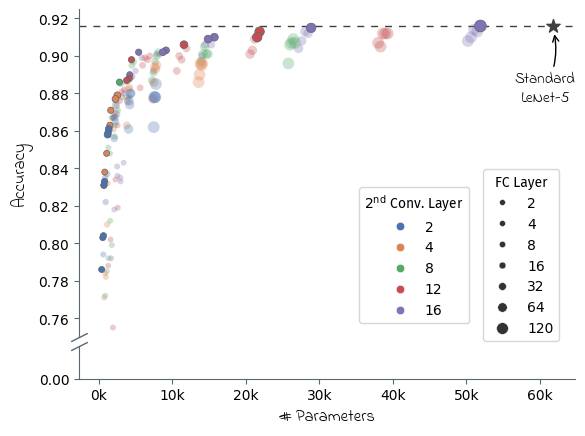

In [6]:
# Sort and filter data
lenet_modified_acc = lenet_modified_acc.sort_values(by=["alpha", "fc"], ascending=[True, True])
lenet_modified_acc = lenet_modified_acc[lenet_modified_acc["Acc@1"] >= 0.75]

# Prepare plot with "broken" axis
# Adapted from https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
with sns.axes_style({"axes.edgecolor": anthracite}):
    fig_lenet_pareto, (ax_top, ax_bottom) = plt.subplots(
        nrows=2,
        ncols=1,
        sharex=True,
        gridspec_kw={
            "height_ratios": [10, 1],
            "hspace": 0.05
        }
    )
kwargs = dict(
    marker=[(-1, -.5), (1, .5)],
    markersize=12,
    linestyle="none",
    mec=anthracite,
    mew=1,
    clip_on=False
)
ax_top.plot(0, transform=ax_top.transAxes, **kwargs)
ax_bottom.plot(1, transform=ax_bottom.transAxes, **kwargs)
ax_bottom.set_ylim(0, 0.5)

# Plot data
ax_top.axhline(
    lenet_standard_acc["Acc@1"][0],
    color=".25",
    linestyle=(0, (5, 5)),
    linewidth=1,
    zorder=-1
)
sns.scatterplot(
    data=lenet_modified_acc,
    x="# Params",
    y="Acc@1",
    hue="conv_2",
    size="fc",
    palette="deep",
    legend=False,
    ax=ax_top,
    alpha=lenet_modified_acc["alpha"],
    edgecolor=anthracite,
    linewidth=lenet_modified_acc["linewidth"]
)
sns.scatterplot(
    data=lenet_modified_acc,
    x="# Params",
    y="Acc@1",
    hue="conv_2",
    size="fc",
    palette="deep",
    legend="full",
    ax=ax_bottom
)
ax_top.scatter(
    data=lenet_standard_acc,
    x="# Params",
    y="Acc@1",
    marker="*",
    color=".25",
    s=100
)
ax_top.annotate(
    "Standard\nLeNet-5",
    xy=(lenet_standard_acc["# Params"][0], lenet_standard_acc["Acc@1"][0]),
    xytext=(lenet_standard_acc["# Params"][0] - 1000, lenet_standard_acc["Acc@1"][0] - 0.04),
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc3,rad=.2",
        shrinkB=6
    ),
    ha="center",
    fontsize=11,
    fontproperties=indie_flower
)

# Add axis labels
ax_bottom.set_xlabel("# Parameters", font=indie_flower, size=12)
ax_top.set_ylabel("Accuracy", font=indie_flower, size=12)
ax_top.set_xlabel("")
ax_bottom.set_ylabel("")

# Customize legend
handles, labels = ax_bottom.get_legend_handles_labels()
ax_bottom.legend().remove()
legend_conv2 = ax_top.legend(
    handles[1:6],
    labels[1:6],
    loc="center left",
    bbox_to_anchor=(0.55, 0.25),
    title=r"$2^{\text{nd}}$ Conv. Layer",
    title_fontproperties=FontProperties(family="Fira Sans")
)
ax_top.legend(
    handles[7:],
    labels[7:],
    loc="center left",
    bbox_to_anchor=(0.8, 0.25),
    title="FC Layer",
    title_fontproperties=FontProperties(family="Fira Sans")
)
ax_top.add_artist(legend_conv2)

# Modify tick labels
ax_bottom.set_xticks([10000 * x for x in range(0, 7)])
ax_bottom.set_xticklabels([f"{10 * x:.0f}k" for x in range(0, 7)])
ax_bottom.set_yticks([0])
ax_bottom.set_yticklabels([f"{0:.2f}"])

# Control figure aesthetics
ax_top.set_ylim(0.75, 0.925)
sns.despine(ax=ax_top, bottom=True)
sns.despine(ax=ax_bottom)
ax_top.tick_params(bottom=False, color=anthracite)
ax_bottom.tick_params(color=anthracite)

plt.show()

## RSA


### Modified LeNet-5

First, we identify the networks to use in the RSA experiments.

In [7]:
# Take a look at all Pareto efficient networks
pareto_efficient = lenet_modified_acc.copy()
pareto_efficient = pareto_efficient[pareto_efficient["efficient"]][["conv_1", "conv_2", "fc", "# Params", "Acc@1"]]
pareto_efficient = pareto_efficient.sort_values(by="# Params")
pareto_efficient

,conv_1,conv_2,fc,# Params,Acc@1
1,2,2,4,408,0.786
71,4,2,4,560,0.803
2,2,2,8,652,0.804
8,2,4,4,710,0.831
37,3,2,8,728,0.831
72,4,2,8,804,0.833
43,3,4,4,836,0.838
113,5,4,4,1088,0.848
38,3,2,16,1216,0.858
44,3,4,8,1280,0.859


In [8]:
# Define thresholds
thresholds = np.linspace(0.78, 0.91, 14)

# For each threshold, find the smallest network reaching/surpassing that threshold
pareto_efficient_subset = []
for threshold in thresholds:
    efficient_network = pareto_efficient[pareto_efficient["Acc@1"] >= threshold].iloc[0].to_frame().T
    efficient_network["threshold"] = threshold
    pareto_efficient_subset.append(efficient_network)
pareto_efficient_subset = pd.concat(pareto_efficient_subset)

# Drop duplicate entries, then add top-performing Pareto efficient model back in
pareto_efficient_final = pareto_efficient_subset.drop_duplicates(subset=["conv_1", "conv_2", "fc"], keep="first")
pareto_efficient_final = pd.concat([
    pareto_efficient_final, pareto_efficient.query("conv_1 == 6 and conv_2 == 16 and fc == 120")
])
pareto_efficient_final[["conv_1", "conv_2", "fc", "# Params"]] = pareto_efficient_final[["conv_1", "conv_2", "fc", "# Params"]].astype(int)
pareto_efficient_final.reset_index(inplace=True, drop=True)
pareto_efficient_final

,conv_1,conv_2,fc,# Params,Acc@1,threshold
0,2,2,4,408,0.786,0.78
1,4,2,4,560,0.803,0.79
2,2,4,4,710,0.831,0.81
3,5,4,4,1088,0.848,0.84
4,3,2,16,1216,0.858,0.85
5,5,2,16,1368,0.861,0.86
6,6,4,8,1658,0.871,0.87
7,5,8,8,2836,0.886,0.88
8,6,16,4,4226,0.890,0.89
9,5,16,8,5444,0.902,0.90


In [9]:
# Print out combinations for use in Hydra config
config_list = []
for idx, row in pareto_efficient_final.iterrows():
    config_list.append(f"{{conv_1: {row['conv_1']:.0f}, conv_2: {row['conv_2']:.0f}, fc: {row['fc']:.0f}}}")
print(",\\\n".join(config_list))

{conv_1: 2, conv_2: 2, fc: 4},\
{conv_1: 4, conv_2: 2, fc: 4},\
{conv_1: 2, conv_2: 4, fc: 4},\
{conv_1: 5, conv_2: 4, fc: 4},\
{conv_1: 3, conv_2: 2, fc: 16},\
{conv_1: 5, conv_2: 2, fc: 16},\
{conv_1: 6, conv_2: 4, fc: 8},\
{conv_1: 5, conv_2: 8, fc: 8},\
{conv_1: 6, conv_2: 16, fc: 4},\
{conv_1: 5, conv_2: 16, fc: 8},\
{conv_1: 6, conv_2: 16, fc: 32},\
{conv_1: 6, conv_2: 16, fc: 120}


### Analyze Results

In [10]:
# Load and prepare data
lenet_modified_rsa = parse_log_dir(
    "../out/lenet_fashionmnist/size_modifications/representational_similarity/2024-10-21_09-55-15",
    parse_fn=get_training_results,
    mode="val"
)
lenet_modified_rsa = lenet_modified_rsa.drop(columns="Accuracy@5")
lenet_modified_rsa = lenet_modified_rsa.rename(columns={"Accuracy@1": "Acc@1"})
lenet_modified_rsa["compute.cntr_actv"] = lenet_modified_rsa["compute.cntr_actv"] == "True"
lenet_modified_rsa["compute"] = lenet_modified_rsa.apply(
    lambda row: row["compute"] if not row["compute.cntr_actv"] else f"{row['compute']}_centered", axis=1
)
lenet_modified_rsa = pd.merge(
    lenet_modified_rsa,
    pareto_efficient_final[["conv_1", "conv_2", "fc", "# Params", "Acc@1"]],
    on=["conv_1", "conv_2", "fc"],
    suffixes=(None, "_prev")
)
lenet_modified_rsa["Acc@1_Loss"] = lenet_modified_rsa.apply(
    lambda row: row["Acc@1_prev"] - row["Acc@1"], axis=1
)
lenet_modified_rsa = lenet_modified_rsa.drop(columns=["compute.cntr_actv", "Acc@1_prev"])
lenet_modified_rsa = lenet_modified_rsa[[
    "compute", "compare", "conv_1", "conv_2", "fc", "# Params", "Loss", "RSAScore", "Acc@1", "Acc@1_Loss", "Epochs"
]]
lenet_modified_rsa = lenet_modified_rsa.sort_values(by=["compute", "compare", "# Params"])
lenet_modified_rsa

,compute,compare,conv_1,conv_2,fc,# Params,Loss,RSAScore,Acc@1,Acc@1_Loss,Epochs
0,correlation,correlation,2,2,4,408,NaN,NaN,NaN,NaN,NaN
3,correlation,correlation,4,2,4,560,NaN,NaN,NaN,NaN,NaN
1,correlation,correlation,2,4,4,710,NaN,NaN,NaN,NaN,NaN
5,correlation,correlation,5,4,4,1088,NaN,NaN,NaN,NaN,NaN
2,correlation,correlation,3,2,16,1216,0.130,0.017,0.844,0.014,83.0
...,...,...,...,...,...,...,...,...,...,...,...
138,euclidean_centered,spearman,5,8,8,2836,0.114,0.014,0.877,0.009,74.0
141,euclidean_centered,spearman,6,16,4,4226,0.125,0.018,0.863,0.027,86.0
139,euclidean_centered,spearman,5,16,8,5444,0.118,0.012,0.878,0.024,42.0
142,euclidean_centered,spearman,6,16,32,15734,0.113,0.031,0.887,0.023,53.0


**Important**: Look at log files to determine which files contain NaN entries!

In [11]:
nan_runs = []

# Find all log files containing NaN values
for root, _, files in os.walk(
    "../out/lenet_fashionmnist/size_modifications/representational_similarity/2024-10-21_09-55-15"
):
    for file in files:
        if file.endswith(".log"):
            log_file_path = os.path.join(root, file)
            first_nan = None
            with open(log_file_path, "r") as f:
                for line in f:
                    if "RSAScore: nan" in line:
                        epoch_match = re.search(r"EPOCH \[(\d+)/\d+\]", line)
                        if epoch_match:
                            first_nan = int(epoch_match.group(1))
                            break
            if first_nan is not None:
                hparams = _extract_hparams(_extract_run_dir(log_file_path))
                hparams["first_nan"] = first_nan
                nan_runs.append(hparams)

# Convert to DataFrame, add # Params, and order rows & cols
nan_df = pd.DataFrame(nan_runs)
nan_df = pd.merge(
    nan_df,
    pareto_efficient_final[["conv_1", "conv_2", "fc", "# Params"]],
    on=["conv_1", "conv_2", "fc"]
)
nan_df = nan_df.sort_values(by=["compute", "compare", "# Params"])
nan_df = nan_df[["compute", "compare", "compute.cntr_actv", "conv_1", "conv_2", "fc", "# Params", "first_nan"]]
nan_df

,compute,compare,compute.cntr_actv,conv_1,conv_2,fc,# Params,first_nan
22,correlation,correlation,None,2,2,4,408,1
6,correlation,correlation,None,4,2,4,560,1
19,correlation,correlation,None,2,4,4,710,1
15,correlation,correlation,None,5,4,4,1088,1
3,correlation,correlation,None,6,4,8,1658,1
11,correlation,correlation,None,6,16,4,4226,1
23,correlation,cosine,None,2,2,4,408,1
7,correlation,cosine,None,4,2,4,560,1
20,correlation,cosine,None,2,4,4,710,1
16,correlation,cosine,None,5,4,4,1088,1


In [12]:
# Print out combinations to note down in README
config_list = []
for idx, row in nan_df.iterrows():
    config_list.append(
        f"* ``conv_1={row['conv_1']:.0f},conv_2={row['conv_2']:.0f},fc={row['fc']:.0f}/"
        f"compute={row['compute']},compare={row['compare']},compute.cntr_actv={row['compute.cntr_actv']}``"
    )
print("\n".join(config_list))

* ``conv_1=2,conv_2=2,fc=4/compute=correlation,compare=correlation,compute.cntr_actv=None``
* ``conv_1=4,conv_2=2,fc=4/compute=correlation,compare=correlation,compute.cntr_actv=None``
* ``conv_1=2,conv_2=4,fc=4/compute=correlation,compare=correlation,compute.cntr_actv=None``
* ``conv_1=5,conv_2=4,fc=4/compute=correlation,compare=correlation,compute.cntr_actv=None``
* ``conv_1=6,conv_2=4,fc=8/compute=correlation,compare=correlation,compute.cntr_actv=None``
* ``conv_1=6,conv_2=16,fc=4/compute=correlation,compare=correlation,compute.cntr_actv=None``
* ``conv_1=2,conv_2=2,fc=4/compute=correlation,compare=cosine,compute.cntr_actv=None``
* ``conv_1=4,conv_2=2,fc=4/compute=correlation,compare=cosine,compute.cntr_actv=None``
* ``conv_1=2,conv_2=4,fc=4/compute=correlation,compare=cosine,compute.cntr_actv=None``
* ``conv_1=5,conv_2=4,fc=4/compute=correlation,compare=cosine,compute.cntr_actv=None``
* ``conv_1=3,conv_2=2,fc=16/compute=correlation,compare=cosine,compute.cntr_actv=None``
* ``conv_1=

<span style="color:red">**Important**</span>: There are **four runs** in which the modified networks end up performing at **chance level**! These are:
* ``conv_1=4,conv_2=2,fc=4/compute=cosine,compare=cosine,compute.cntr_actv=None``
* ``conv_1=5,conv_2=4,fc=4/compute=cosine,compare=cosine,compute.cntr_actv=None``
* ``conv_1=5,conv_2=2,fc=16/compute=cosine,compare=cosine,compute.cntr_actv=None``
* ``conv_1=3,conv_2=2,fc=16/compute=correlation,compare=cosine,compute.cntr_actv=None``

Consequently, these networks suffer a dramatic drop in classification accuracy, and hence are **excluded** in the analysis below!

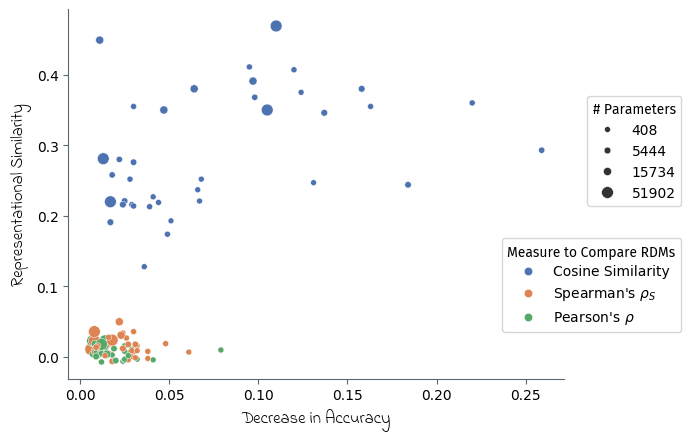

In [13]:
# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    ax = sns.scatterplot(
        data=lenet_modified_rsa[lenet_modified_rsa["Acc@1"] > 0.1],  # excludes 4 networks performing at chance level
        x="Acc@1_Loss",  # decrease in accuracy
        y="RSAScore",
        hue="compare",
        size="# Params",
        palette="deep",
        hue_order=["cosine", "spearman", "correlation"],
        legend="full"
    )

# Add axis labels
ax.set_xlabel("Decrease in Accuracy", font=indie_flower, size=12)
ax.set_ylabel("Representational Similarity", font=indie_flower, size=12)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()
sizes = ["408", "5444", "15734", "51902"]
legend_sizes = ax.legend(
    [h for l, h in zip(labels, handles) if l in sizes],
    sizes,
    loc="lower right",
    bbox_to_anchor=(1.25, 0.45),
    title="# Parameters",
    title_fontproperties=FontProperties(family="Fira Sans")
)
ax.legend(
    handles[1:4],
    ["Cosine Similarity", r"Spearman's $\rho_S$", r"Pearson's $\rho$"],
    loc="upper right",
    bbox_to_anchor=(1.25, 0.4),
    title="Measure to Compare RDMs",
    title_fontproperties=FontProperties(family="Fira Sans")
)
ax.add_artist(legend_sizes)

# Control figure aesthetics
sns.despine(ax=ax)
ax.tick_params(color=anthracite)

fig_repr_sim_vs_accuracy = ax.get_figure()
plt.show()

In [14]:
save_figure(
    fig_repr_sim_vs_accuracy,
    "../reports/figures/lenet_fashionmnist/size_modifications/similarity_vs_accuracy.png"
)

Figure saved successfully as ../reports/figures/lenet_fashionmnist/size_modifications/similarity_vs_accuracy.png.
